In [1]:
!pip install gpflow
!pip install utils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.7/376.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [3]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob


def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    Y_all = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))

    return Y, length_all


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [5]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [6]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [7]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [8]:
y_train_df

latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   
...             ...       ...       ...       ...       ...       ...   
748        0.596715  0.597041  0.596959  0.596970  0.596985  0.596959   
749        0.918666  0.918844  0.918686  0.918681  0.918676  0.918655   
750        0.960892  0.961212  0.961222  0.960943  0.961222  0.961121   
751        0.916865  0.916743  0.916606  0.916662  0.916667  0.916631   
752        1.127218  1.127263  1.127238  1.127233  1.127253  1.127202   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   
...             ...       ...       ...       ...  ...       ...       ...   
748        0.596959  0.596965  0.596817  0.596944  ...  2.024526  2.024689   
749        0.918666  0.918660  0.918462  0.918493  ...  3.675151  3.674947   
750        0.960963  0.961222  0.961029  0.961004  ...  3.218984  3.219035   
751        0.916656  0.916646  0.916468  0.916458  ...  2.249318  2.249095   
752        1.127253  1.127233  1.127268  1.127314  ...  2.610921  2.610870   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   
...             ...       ...       ...       ...       ...       ...   
748        2.012695  2.000763  2.000722  2.000590  2.000488  2.000631   
749        3.682241  3.689789  3.689870  3.689992  3.690033  3.690603   
750        3.211863  3.204803  3.204742  3.204631  3.204692  3.204763   
751        2.243428  2.237996  2.238261  2.238678  2.239177  2.239929   
752        2.610067  2.609406  2.609487  2.609578  2.609761  2.609945   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  
...             ...       ...  
748        2.000468  2.000621  
749        3.690918  3.691579  
750        3.204844  3.205027  
751        2.240936  2.242371  
752        2.610291  2.610931  

[753 rows x 13824 columns]

In [8]:
# Standardize the predictors
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test  = X_test_df.to_numpy()


In [9]:
# Standardize the predictand
y_train    = y_train_df.to_numpy().astype(np.float64)
train_tas_mean, train_tas_std = y_train.mean(), y_train.std()
y_train    = (y_train - train_tas_mean) / train_tas_std


print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 13824) (86, 2)


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error



# Step 3: Scale your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)

In [66]:
y_train_scaled

array([[-0.436101  , -0.43639052, -0.43640318, ..., -0.46483082,
        -0.46498146, -0.46514197],
       [-1.27001935, -1.27001983, -1.27004392, ..., -0.7679234 ,
        -0.76814736, -0.76845457],
       [-0.75568056, -0.75575811, -0.75577185, ..., -0.37289323,
        -0.37282411, -0.3727343 ],
       ...,
       [ 0.1051952 ,  0.10524556,  0.10531212, ...,  0.34508106,
         0.34502656,  0.34493251],
       [ 0.06800903,  0.0676853 ,  0.06762713, ...,  0.00422953,
         0.00452658,  0.00490545],
       [ 0.24567878,  0.2454984 ,  0.24553528, ...,  0.1349467 ,
         0.13500077,  0.13508751]])

In [69]:
y_train

array([[-0.31154457, -0.31159335, -0.31164539, ...,  0.06707723,
         0.06684956,  0.06671297],
       [-0.94283022, -0.9426546 , -0.94271314, ..., -0.48149071,
        -0.48189072, -0.48234276],
       [-0.55346992, -0.5533561 , -0.55340813, ...,  0.23347529,
         0.23365738,  0.2339891 ],
       ...,
       [ 0.09822279,  0.09842767,  0.09843419, ...,  1.5329386 ,
         1.53299074,  1.53310781],
       [ 0.07007244,  0.06999438,  0.06990658, ...,  0.91603064,
         0.91667456,  0.91759166],
       [ 0.20457045,  0.20459972,  0.20458341, ...,  1.15261595,
         1.15283715,  1.15324691]])

In [10]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
svr = SVR()

# Create the MultiOutputRegressor with SVR
model = MultiOutputRegressor(svr)

# Fit the model
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

In [47]:
a = X_test[['CO2','CH4']]

In [53]:
y_test = y_test_xr.values

In [11]:
y_pred = model.predict(X_test)

In [12]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values,
                               'latitude': X_test_xr.latitude.values,
                               'longitude': X_test_xr.longitude.values},
                        data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

In [32]:
!pip install eofs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100355 sha256=4c7d1fcf8b20c8c8a57e07bd64d8b92b111e93b8df95881f3b2db0c156df8394
  Stored in directory: /root/.cache/pip/wheels/3d/69/36/c8bd247900ab5ade980a418ac2faed41e08f5006f7c369282f
Successfully built eofs


In [39]:
import numpy as np
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
# data_path = './data/train_val/'
data_path = "/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/"

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4


def create_predictor_data(data_sets, n_eofs=5):
    """
    Args:
        data_sets list(str): names of datasets
        n_eofs (int): number of eofs to create for aerosol variables
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs, (so2_solver, bc_solver)


def get_test_data(file, eof_solvers, n_eofs=5):
    """
    Args:
        file str: name of datasets
        n_eofs (int): number of eofs to create for aerosol variables
        eof_solvers (Eof_so2, Eof_bc): Fitted Eof objects to use for projection
    """

    # Create training and testing arrays
    X = xr.open_dataset(data_path + f"inputs_{file}.nc")

    so2_pcs = eof_solvers[0].projectField(X["SO2"], neofs=5, eofscaling=1)
    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    bc_pcs = eof_solvers[1].projectField(X["BC"], neofs=5, eofscaling=1)
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs


def create_predictdand_data(data_sets):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [40]:
## Test on SSP245
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)
X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data(['ssp245'])

tas_truth = Y_test["tas"]
#pr_truth = Y_test["pr"]
#pr90_truth = Y_test["pr90"]
#dtr_truth = Y_test["diurnal_temperature_range"]

In [49]:
#m_out_tas, _ = model.predict(X_test)
#m_out_pr, _ = rf_pr.predict(X_test)
#m_out_pr90, _ = rf_pr90.predict(X_test)
#m_out_dtr, _ = rf_dtr.predict(X_test)

In [50]:
#print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
#print("\n")

In [16]:
y_pred

array([[0.12132806, 0.12161923, 0.12124505, ..., 1.5674724 , 1.56765441,
        1.56742888],
       [0.13336949, 0.1336119 , 0.13328734, ..., 1.5919084 , 1.5921009 ,
        1.5919084 ],
       [0.14564978, 0.14584334, 0.14556864, ..., 1.61647789, 1.61668074,
        1.61652182],
       ...,
       [0.81891475, 0.81893122, 0.82007357, ..., 2.80636756, 2.80645828,
        2.80687762],
       [0.82014855, 0.82017254, 0.82131589, ..., 2.81029601, 2.81038589,
        2.81079731],
       [0.82133611, 0.82136729, 0.82251163, ..., 2.81404117, 2.81413019,
        2.81453394]])

In [20]:
a = y_test_pre.to_array()
a

<xarray.DataArray (variable: 1, time: 86, latitude: 96, longitude: 144)>
array([[[[0.12132806, 0.12161923, 0.12124505, ..., 0.12114052,
          0.12125589, 0.12124233],
         [0.18424754, 0.18270495, 0.18179991, ..., 0.19128097,
          0.19027211, 0.18604058],
         [0.18931582, 0.19083485, 0.1912516 , ..., 0.17567262,
          0.17578515, 0.18945403],
         ...,
         [1.45950448, 1.46205869, 1.45970661, ..., 1.45789204,
          1.45746526, 1.46028454],
         [1.51940267, 1.5142305 , 1.51388981, ..., 1.50316217,
          1.50944029, 1.52397368],
         [1.56725697, 1.56491756, 1.55895465, ..., 1.5674724 ,
          1.56765441, 1.56742888]],

        [[0.13336949, 0.1336119 , 0.13328734, ..., 0.13316783,
          0.13331177, 0.1332819 ],
         [0.19679385, 0.19505486, 0.19389138, ..., 0.20453524,
          0.2035439 , 0.19866543],
         [0.20238626, 0.20397099, 0.20450253, ..., 0.18857687,
          0.18795892, 0.20154926],
...
         [2.45174486, 2.4657916 , 2.48074017, ..., 2.4926248 ,
          2.4904824 , 2.4709411 ],
         [2.68158038, 2.68668069, 2.69767523, ..., 2.70802341,
          2.69261628, 2.68595567],
         [2.81087663, 2.80958085, 2.79995261, ..., 2.81029601,
          2.81038589, 2.81079731]],

        [[0.82133611, 0.82136729, 0.82251163, ..., 0.8215885 ,
          0.82234632, 0.82186912],
         [0.93897675, 0.94122657, 0.93951666, ..., 0.91887465,
          0.92922921, 0.93127923],
         [0.83110885, 0.83490121, 0.83403199, ..., 0.75885495,
          0.79898182, 0.81024684],
         ...,
         [2.45521698, 2.46922491, 2.48451263, ..., 2.49611743,
          2.49379497, 2.47413474],
         [2.68549142, 2.69057591, 2.70158877, ..., 2.71198053,
          2.69660553, 2.689881  ],
         [2.81461041, 2.8133141 , 2.80370424, ..., 2.81404117,
          2.81413019, 2.81453394]]]])
Coordinates:
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * variable   (variable) object 'tas'

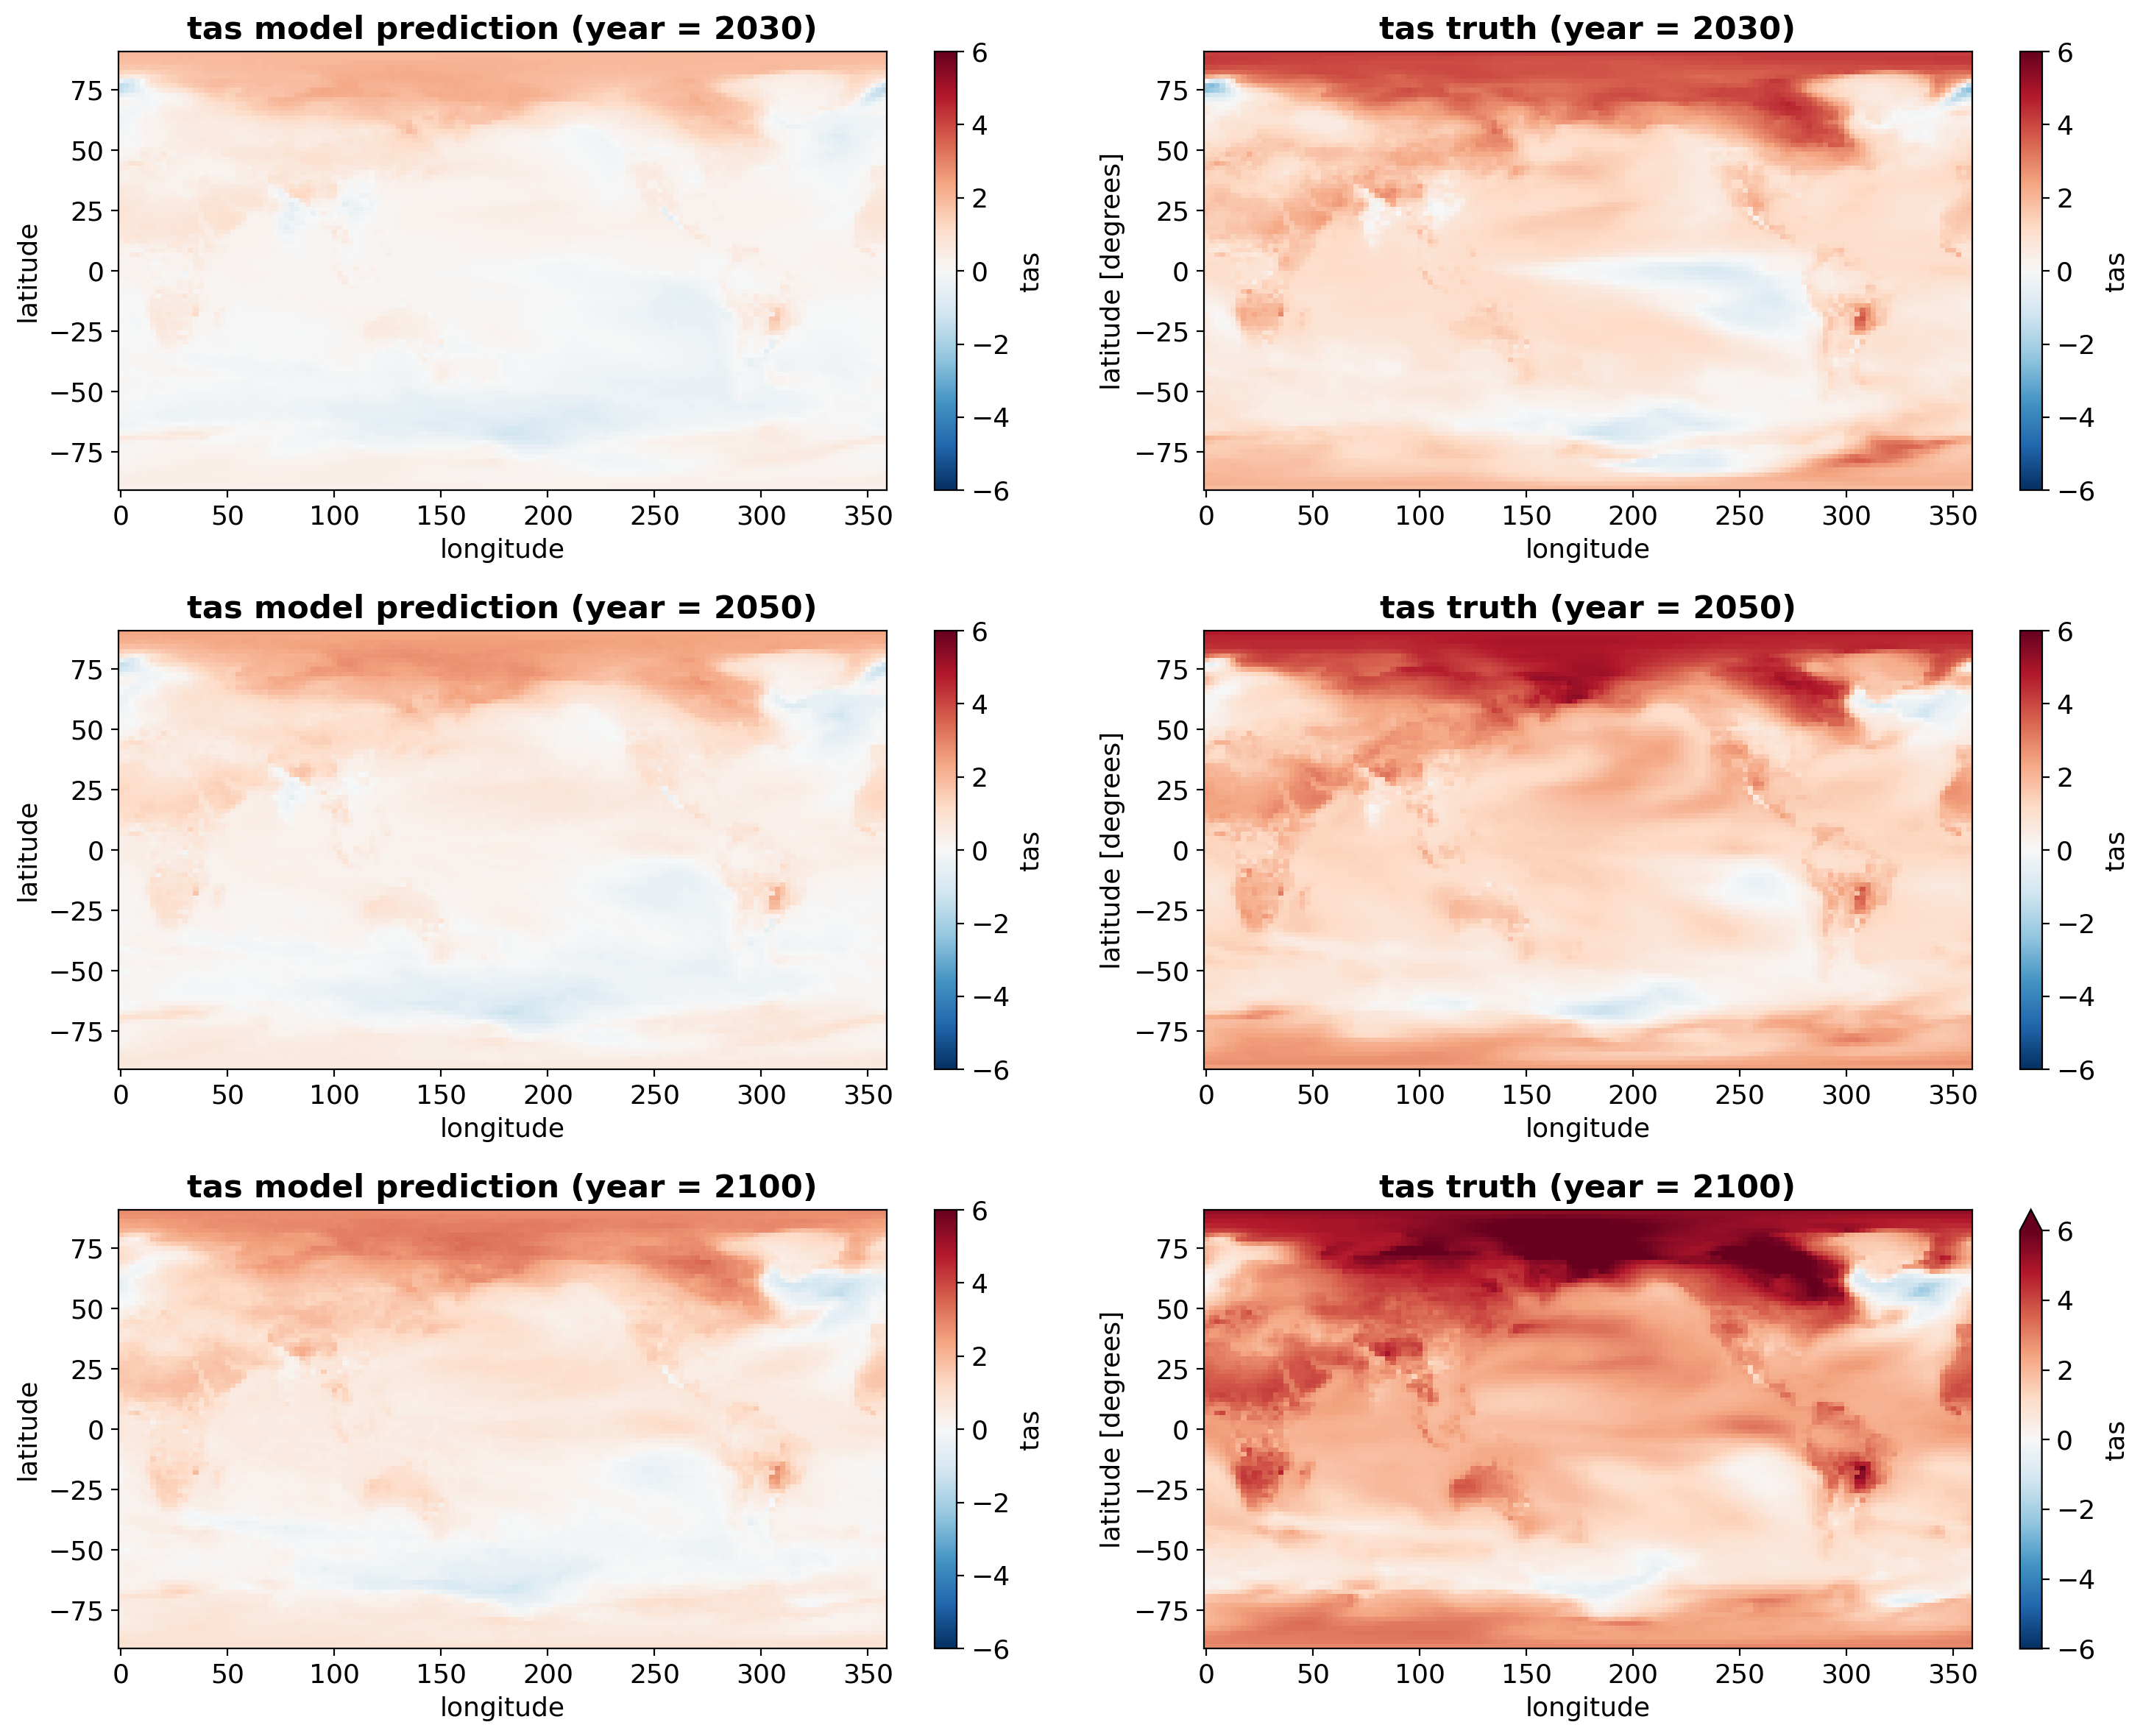

In [27]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

In [59]:
y_test

<bound method Mapping.values of <xarray.Dataset>
Dimensions:                    (latitude: 96, longitude: 144, time: 86)
Coordinates:
  * latitude                   (latitude) float64 -90.0 -88.11 ... 88.11 90.0
  * longitude                  (longitude) float64 0.0 2.5 5.0 ... 355.0 357.5
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 0.09798 .....
    tas                        (time, latitude, longitude) float32 1.475 ... ...
    pr                         (time, latitude, longitude) float32 3.614e-07 ...
    pr90                       (time, latitude, longitude) float64 8.739e-07 ...>

In [58]:
y_test_df = y_test_xr["tas"].stack(dim=["latitude", "longitude"])
y_test_df = pd.DataFrame(y_test_df.to_pandas())

In [61]:
y_test = y_test_df.to_numpy()

In [63]:
y_test

array([[1.4753824, 1.4754995, 1.4754333, ..., 2.3569438, 2.3573406,
        2.3577168],
       [1.2637278, 1.2639517, 1.2639618, ..., 2.973755 , 2.9739277,
        2.9743652],
       [1.0368601, 1.0371145, 1.0371094, ..., 4.289846 , 4.289907 ,
        4.290212 ],
       ...,
       [2.4131825, 2.413213 , 2.4131367, ..., 7.0556436, 7.0562644,
        7.057241 ],
       [2.3748677, 2.3749492, 2.3749592, ..., 5.992859 , 5.993042 ,
        5.993418 ],
       [2.8937428, 2.8941193, 2.8941243, ..., 5.2635903, 5.2644553,
        5.2655945]], dtype=float32)

In [56]:
y_pred

array([[0.12132806, 0.12161923, 0.12124505, ..., 1.5674724 , 1.56765441,
        1.56742888],
       [0.13336949, 0.1336119 , 0.13328734, ..., 1.5919084 , 1.5921009 ,
        1.5919084 ],
       [0.14564978, 0.14584334, 0.14556864, ..., 1.61647789, 1.61668074,
        1.61652182],
       ...,
       [0.81891475, 0.81893122, 0.82007357, ..., 2.80636756, 2.80645828,
        2.80687762],
       [0.82014855, 0.82017254, 0.82131589, ..., 2.81029601, 2.81038589,
        2.81079731],
       [0.82133611, 0.82136729, 0.82251163, ..., 2.81404117, 2.81413019,
        2.81453394]])

In [64]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

In [71]:
# predict
#standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
#posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
#posterior_std = np.sqrt(standard_posterior_var) * train_tas_std
# put output back into xarray format for calculating RMSE/plotting
#posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
#posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])

#posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
#posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

In [70]:
# Compute RMSEs
#print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
#print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
#print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
#print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
#print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

In [65]:
mse

2.1479266685466913

In [67]:
rmse = np.sqrt(mse)
rmse

1.4655806591746123

In [76]:
a = pd.DataFrame(y_pred)

In [73]:
data_array = xr.DataArray(y_pred)
data_array1 = xr.DataArray(y_test)

In [75]:
data_array1

<xarray.DataArray (dim_0: 86, dim_1: 13824)>
array([[1.4753824, 1.4754995, 1.4754333, ..., 2.3569438, 2.3573406,
        2.3577168],
       [1.2637278, 1.2639517, 1.2639618, ..., 2.973755 , 2.9739277,
        2.9743652],
       [1.0368601, 1.0371145, 1.0371094, ..., 4.289846 , 4.289907 ,
        4.290212 ],
       ...,
       [2.4131825, 2.413213 , 2.4131367, ..., 7.0556436, 7.0562644,
        7.057241 ],
       [2.3748677, 2.3749492, 2.3749592, ..., 5.992859 , 5.993042 ,
        5.993418 ],
       [2.8937428, 2.8941193, 2.8941243, ..., 5.2635903, 5.2644553,
        5.2655945]], dtype=float32)
Dimensions without coordinates: dim_0, dim_1

In [74]:
data_array

<xarray.DataArray (dim_0: 86, dim_1: 13824)>
array([[0.12132806, 0.12161923, 0.12124505, ..., 1.5674724 , 1.56765441,
        1.56742888],
       [0.13336949, 0.1336119 , 0.13328734, ..., 1.5919084 , 1.5921009 ,
        1.5919084 ],
       [0.14564978, 0.14584334, 0.14556864, ..., 1.61647789, 1.61668074,
        1.61652182],
       ...,
       [0.81891475, 0.81893122, 0.82007357, ..., 2.80636756, 2.80645828,
        2.80687762],
       [0.82014855, 0.82017254, 0.82131589, ..., 2.81029601, 2.81038589,
        2.81079731],
       [0.82133611, 0.82136729, 0.82251163, ..., 2.81404117, 2.81413019,
        2.81453394]])
Dimensions without coordinates: dim_0, dim_1

In [77]:
a

,0,1,2,3,4,5,6,7,8,9,...,13814,13815,13816,13817,13818,13819,13820,13821,13822,13823
0,0.121328,0.121619,0.121245,0.121714,0.121831,0.121121,0.121287,0.121100,0.121564,0.121910,...,1.576002,1.575596,1.571856,1.567610,1.566926,1.567497,1.567156,1.567472,1.567654,1.567429
1,0.133369,0.133612,0.133287,0.133743,0.133860,0.133158,0.133306,0.133126,0.133585,0.133926,...,1.600333,1.599964,1.596262,1.592003,1.591343,1.591911,1.591592,1.591908,1.592101,1.591908
2,0.145650,0.145843,0.145569,0.146011,0.146128,0.145435,0.145565,0.145392,0.145844,0.146181,...,1.624777,1.624450,1.620790,1.616529,1.615894,1.616458,1.616162,1.616478,1.616681,1.616522
3,0.158159,0.158304,0.158079,0.158508,0.158625,0.157941,0.158054,0.157887,0.158333,0.158666,...,1.649316,1.649033,1.645421,1.641169,1.640560,1.641121,1.640847,1.641162,1.641375,1.641250
4,0.170887,0.170983,0.170809,0.171224,0.171342,0.170666,0.170762,0.170602,0.171041,0.171370,...,1.673930,1.673695,1.670136,1.665904,1.665322,1.665879,1.665629,1.665941,1.666164,1.666074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.816305,0.816306,0.817446,0.817938,0.818796,0.818487,0.818659,0.817998,0.818513,0.819738,...,2.782507,2.786653,2.791557,2.797250,2.797872,2.797900,2.798657,2.797963,2.798055,2.798491
82,0.817634,0.817643,0.818784,0.819280,0.820142,0.819831,0.820009,0.819342,0.819860,0.821095,...,2.786767,2.790908,2.795841,2.801552,2.802168,2.802196,2.802947,2.802256,2.802348,2.802775
83,0.818915,0.818931,0.820074,0.820575,0.821440,0.821127,0.821312,0.820638,0.821158,0.822403,...,2.790848,2.794984,2.799944,2.805672,2.806282,2.806310,2.807056,2.806368,2.806458,2.806878
84,0.820149,0.820173,0.821316,0.821821,0.822689,0.822375,0.822566,0.821886,0.822408,0.823663,...,2.794750,2.798881,2.803866,2.809609,2.810214,2.810241,2.810981,2.810296,2.810386,2.810797


NameError: ignored

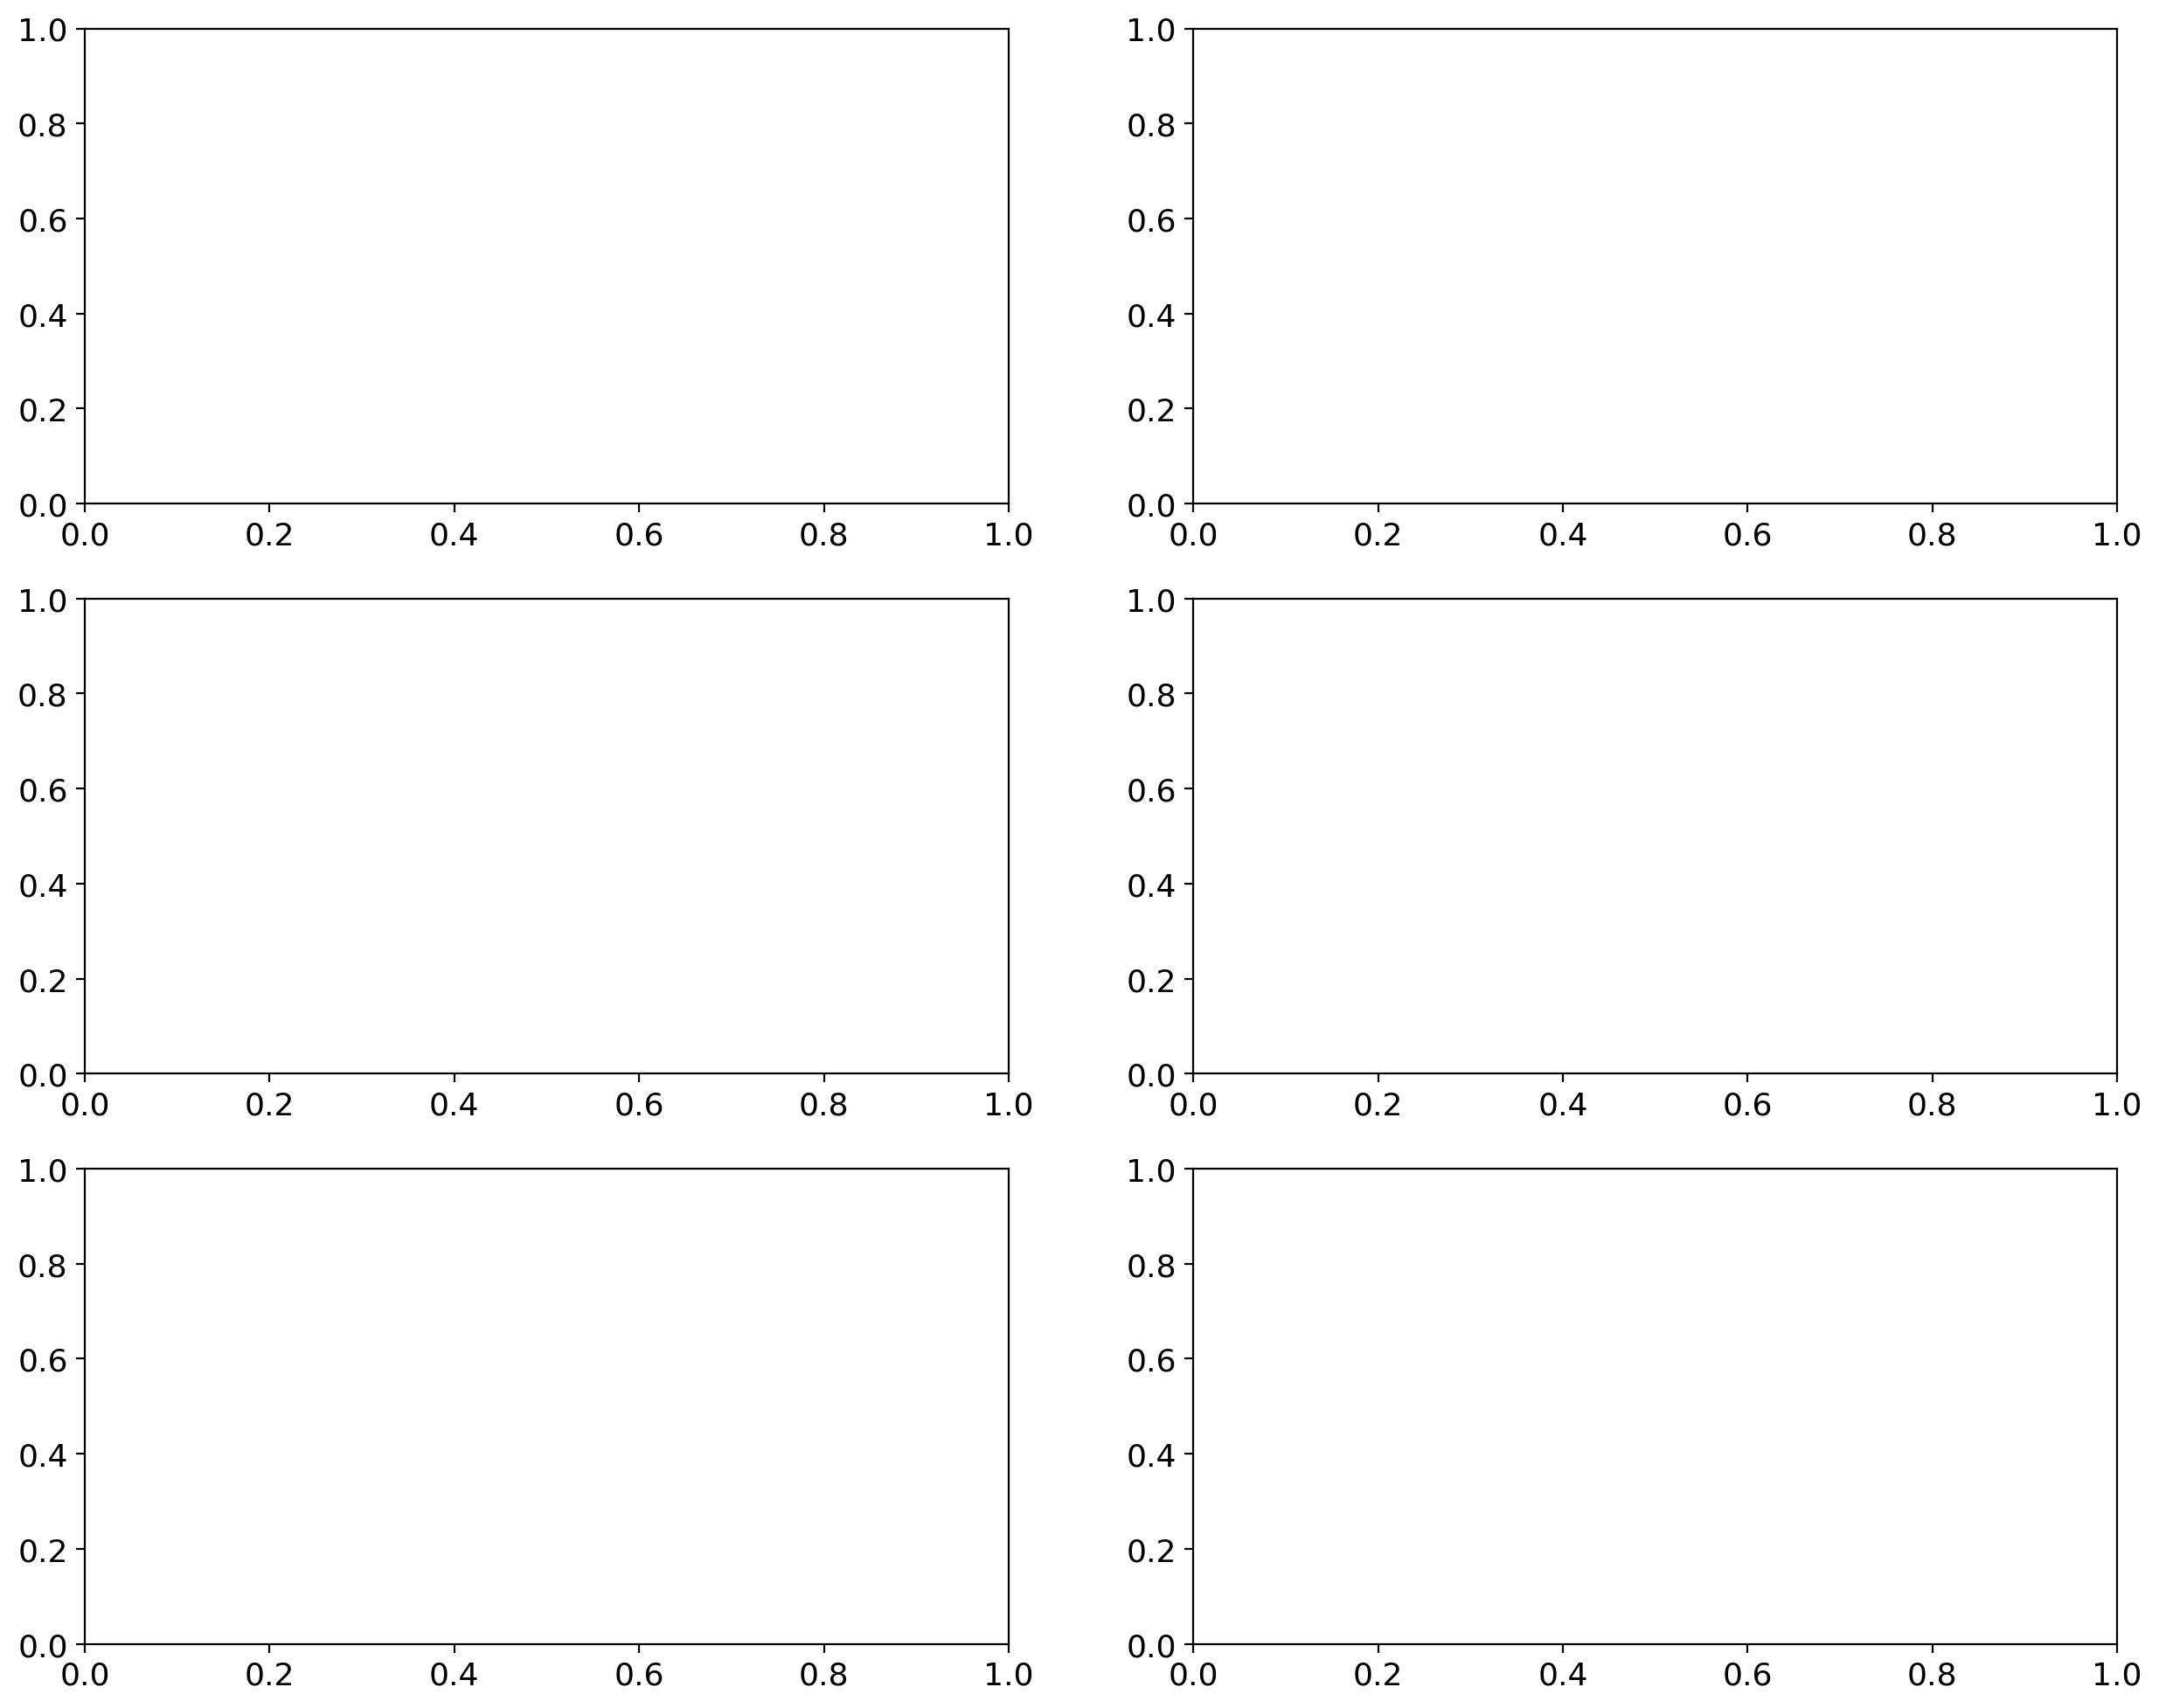

In [75]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

In [68]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train_scaled,y_train)

ValueError: ignored

In [11]:
X_train = X_train.reshape(X_train.shape[0], -1)

In [41]:
#X_train

In [13]:

X_test = X_test.reshape(X_test.shape[0], -1)

In [14]:
X_test

array([[0.06571835, 0.77723954],
       [0.08368938, 0.77716197],
       [0.10183485, 0.77708441],
       [0.12015477, 0.77700684],
       [0.13864913, 0.77692928],
       [0.15731793, 0.77685171],
       [0.17614691, 0.78219052],
       [0.19513606, 0.78752932],
       [0.21428539, 0.79286813],
       [0.23359488, 0.79820694],
       [0.25306456, 0.80354574],
       [0.2726944 , 0.80888455],
       [0.29248442, 0.81422335],
       [0.31243461, 0.81956216],
       [0.33254498, 0.82490097],
       [0.35281552, 0.83023977],
       [0.37316068, 0.82218397],
       [0.39358046, 0.81412817],
       [0.41407487, 0.80607237],
       [0.43464391, 0.79801657],
       [0.45528756, 0.78996077],
       [0.47600584, 0.78190497],
       [0.49679875, 0.77384917],
       [0.51766627, 0.76579337],
       [0.53860842, 0.75773757],
       [0.5596252 , 0.74968177],
       [0.58068557, 0.73733808],
       [0.60178953, 0.7249944 ],
       [0.6229371 , 0.71265072],
       [0.64412826, 0.70030704],
       [0.

In [25]:
y_train1 = y_train

In [29]:
X_train

array([[-0.70129109, -0.86614568],
       [-0.70119673, -0.8640538 ],
       [-0.70109856, -0.86196191],
       ...,
       [ 0.012457  ,  0.74256066],
       [ 0.03013463,  0.75821324],
       [ 0.04792176,  0.76509004]])

In [57]:
y_train

array([[-0.31154457, -0.31159335, -0.31164539, ...,  0.06707723,
         0.06684956,  0.06671297],
       [-0.94283022, -0.9426546 , -0.94271314, ..., -0.48149071,
        -0.48189072, -0.48234276],
       [-0.55346992, -0.5533561 , -0.55340813, ...,  0.23347529,
         0.23365738,  0.2339891 ],
       ...,
       [ 0.09822279,  0.09842767,  0.09843419, ...,  1.5329386 ,
         1.53299074,  1.53310781],
       [ 0.07007244,  0.06999438,  0.06990658, ...,  0.91603064,
         0.91667456,  0.91759166],
       [ 0.20457045,  0.20459972,  0.20458341, ...,  1.15261595,
         1.15283715,  1.15324691]])

In [44]:
d = []
for i in y_train:
  d.append(i[0])

In [45]:
d

[-0.3115445710053462,
 -0.9428302168308756,
 -0.5534699211693397,
 -0.4356845688027967,
 -0.24870381921240542,
 -0.6116471325159143,
 -0.8110119591885184,
 -0.142109006450986,
 -0.49745537288218955,
 -0.48948442087383326,
 -0.5988988114272505,
 -0.5623091861565194,
 -0.12658338912511463,
 -0.815815349611021,
 -0.22205918435034652,
 -0.7434686391042878,
 -0.666455136823247,
 -0.47348723237249,
 -0.2679238597390462,
 -0.29871495004466975,
 -0.4449466136089995,
 -0.14965395470451787,
 -0.3809188389044786,
 -0.34574713084959996,
 -0.6963421340601772,
 -0.26900355786353064,
 -0.12234588697148863,
 -0.5349848594018577,
 -0.5887749574890699,
 -0.8185731426444304,
 -0.7777037265195074,
 -0.23911980957261658,
 -0.6768001334638009,
 -0.06828258682403629,
 -0.9911664921725303,
 -0.2720280312458955,
 -0.4218207730726665,
 -0.2414906064497606,
 0.015706688384839955,
 -0.5590733264375308,
 -0.5563513003934025,
 -0.4940341410229967,
 -0.6575313206361132,
 -0.4456620772547339,
 -0.33094998248122875,
 

In [46]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train,d)

SVR()

In [39]:
a = y_test_xr.to_array

In [71]:

#y_pred = sc_y.inverse_transform(y_pred)
#b = y_pred.to_dataframe()
b = pd.DataFrame(y_pred)

NotFittedError: ignored

In [55]:
b

,0
0,0.121328
1,0.133369
2,0.145650
3,0.158159
4,0.170887
...,...
81,0.816305
82,0.817634
83,0.818915
84,0.820149
